In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv', index_col='id')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv', index_col='id')
submission = pd.read_csv('/kaggle/input/playground-series-s4e3/sample_submission.csv', index_col='id')

pd.concat([train_data, test_data]).info()

<class 'pandas.core.frame.DataFrame'>
Index: 32033 entries, 0 to 32032
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              32033 non-null  int64  
 1   X_Maximum              32033 non-null  int64  
 2   Y_Minimum              32033 non-null  int64  
 3   Y_Maximum              32033 non-null  int64  
 4   Pixels_Areas           32033 non-null  int64  
 5   X_Perimeter            32033 non-null  int64  
 6   Y_Perimeter            32033 non-null  int64  
 7   Sum_of_Luminosity      32033 non-null  int64  
 8   Minimum_of_Luminosity  32033 non-null  int64  
 9   Maximum_of_Luminosity  32033 non-null  int64  
 10  Length_of_Conveyer     32033 non-null  int64  
 11  TypeOfSteel_A300       32033 non-null  int64  
 12  TypeOfSteel_A400       32033 non-null  int64  
 13  Steel_Plate_Thickness  32033 non-null  int64  
 14  Edges_Index            32033 non-null  float64
 15  Empty_I

* Combining the datasets, we can see there are no null values across both the training and testing data. 
* Target values are binary (0/1), and below you can see that many of these features are unbalanced.
* All features appear to be numerical.

In [3]:
target_features = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
pd.concat([train_data, test_data]).drop(columns=target_features).describe(percentiles=[]).drop('count').T

,mean,std,min,50%,max
X_Minimum,7.096453e+02,5.316697e+02,0.0000,7.770000e+02,1.705000e+03
X_Maximum,7.536245e+02,5.001919e+02,4.0000,7.960000e+02,1.713000e+03
Y_Minimum,1.848467e+06,1.908685e+06,6712.0000,1.388373e+06,1.298766e+07
Y_Maximum,1.844775e+06,1.902334e+06,6724.0000,1.388398e+06,1.298769e+07
Pixels_Areas,1.679556e+03,3.728346e+03,4.0000,1.690000e+02,1.526550e+05
X_Perimeter,9.597662e+01,1.957523e+02,2.0000,2.500000e+01,1.044900e+04
Y_Perimeter,6.436672e+01,1.426217e+02,1.0000,2.400000e+01,1.815200e+04
Sum_of_Luminosity,1.921837e+05,4.581274e+05,250.0000,1.836100e+04,1.159141e+07
Minimum_of_Luminosity,8.470427e+01,2.876470e+01,0.0000,9.000000e+01,2.030000e+02
Maximum_of_Luminosity,1.286640e+02,1.423044e+01,37.0000,1.270000e+02,2.530000e+02


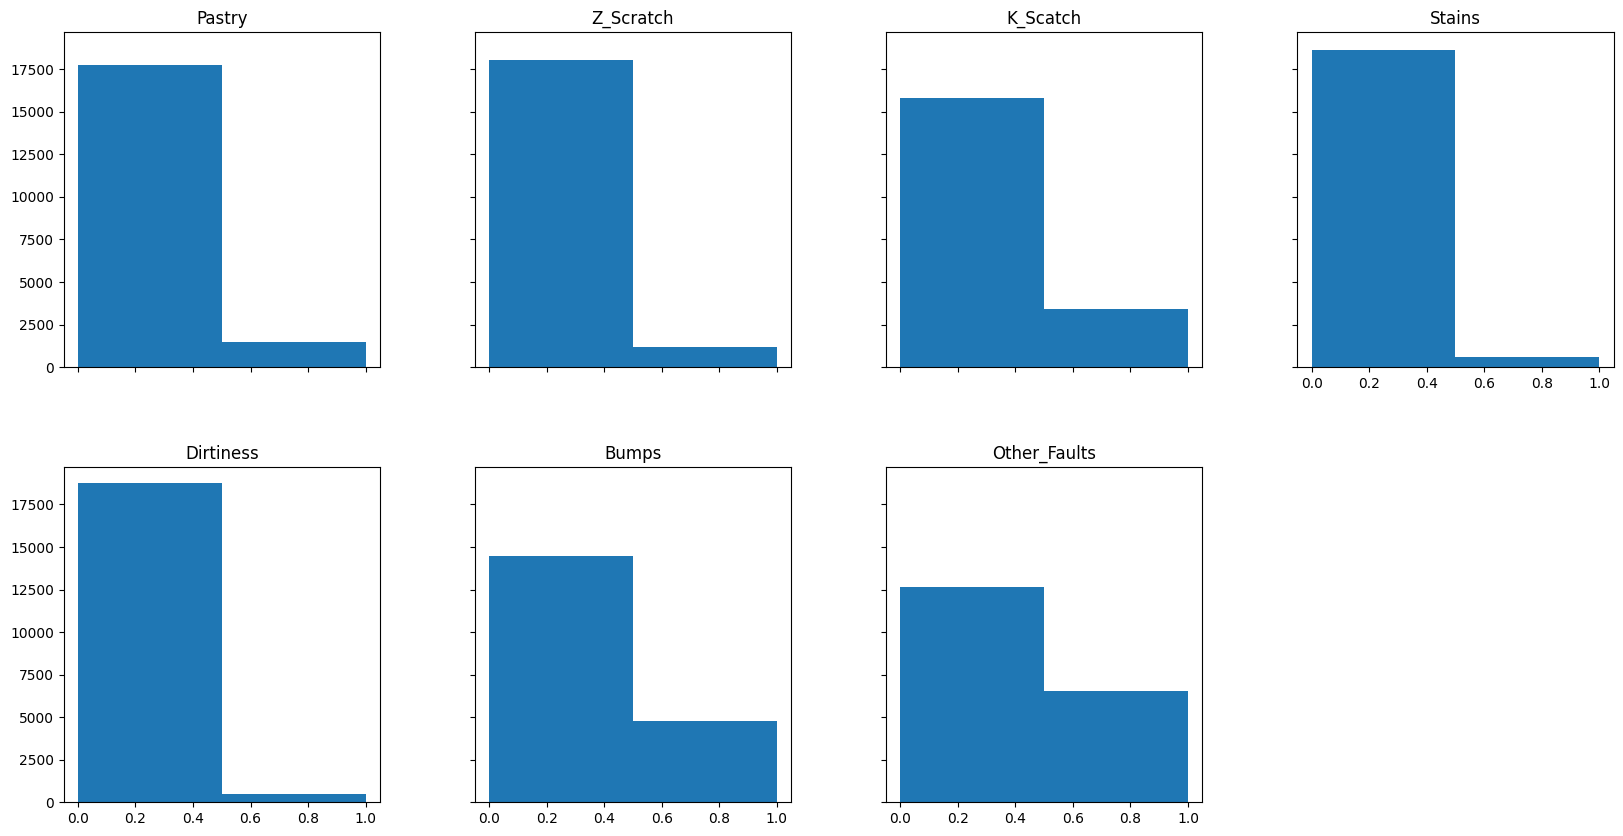

In [4]:
train_data[target_features].hist(grid=False, sharex=True, sharey=True, layout=(2, 4), bins=2, figsize=(20,10))
plt.show()

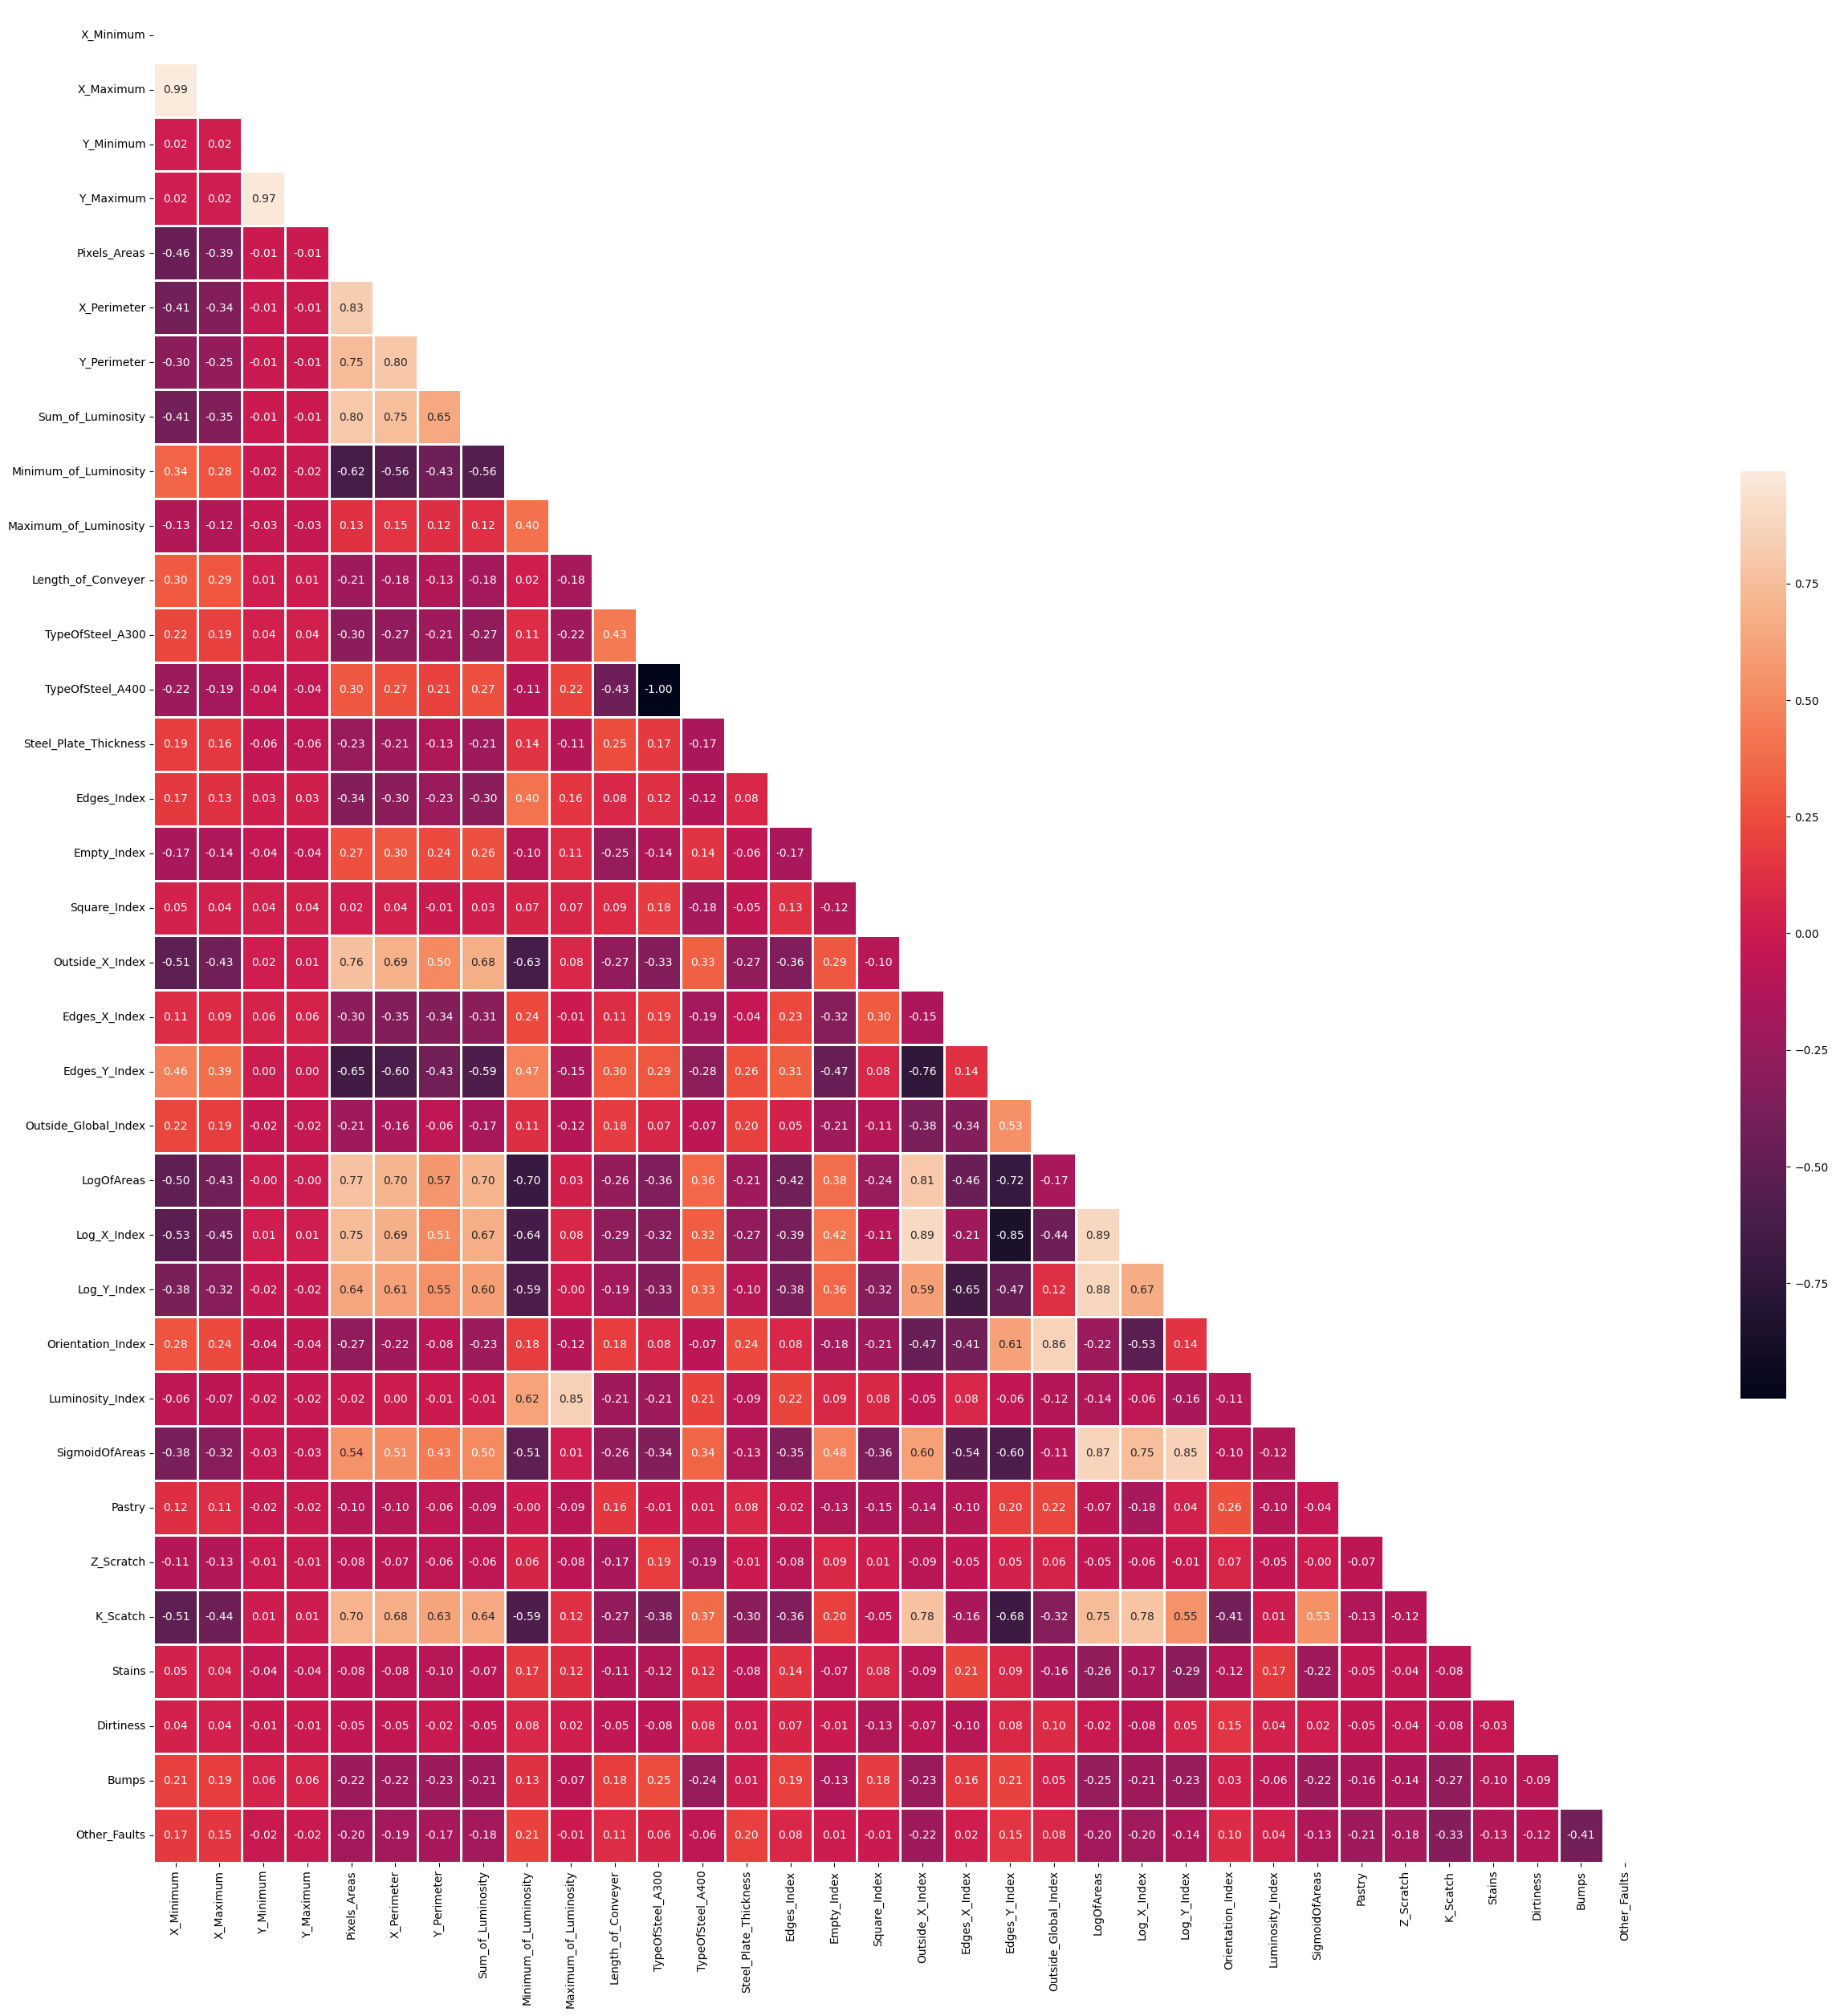

In [5]:
corr = pd.concat([train_data, test_data]).corr(numeric_only=True)

plt.figure(figsize=(30, 30))
sns.heatmap(corr, mask=np.triu(corr), linewidth=1, annot=True, fmt='.2f', cbar_kws={"shrink": .5})
plt.show()

In [6]:
# def add_new_features(df):
#     df['X_Range'] = df['X_Maximum'] - df['X_Minimum']
#     df['Y_Range'] = df['Y_Maximum'] - df['Y_Minimum']
#     df['Range_of_Luminosity'] = df['Maximum_of_Luminosity'] - df['Minimum_of_Luminosity']

#     df['Total_Perimeter'] = df['X_Perimeter'] + df['Y_Perimeter']
#     df['Area_Perimeter_Ratio'] = df['Pixels_Areas'] / df['Total_Perimeter']
    
#     return df

# train_data = add_new_features(train_data)
# print("All Features: \n", train_data.columns.values)

In [7]:
def get_fitted_xgboost_model(data, params = {}):
    transformed_data = StandardScaler().fit_transform(data)
    
    X = pd.DataFrame(transformed_data, columns=data.columns.values).drop(columns=target_features)
    y = data[target_features].idxmax(1).map({'Pastry':0, 'Z_Scratch':1,'K_Scatch':2,'Stains':3,
                                             'Dirtiness':4,'Bumps':5,'Other_Faults':6})
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    return clf, X_test, y_test

In [8]:
clf, X_test, y_test = get_fitted_xgboost_model(train_data)
y_proba = pd.DataFrame(clf.predict_proba(X_test), columns=target_features, index=y_test.index)
print('Score: %.2f' % (clf.score(X_test, y_test)*100) + '%\n')

Score: 56.16%



In [9]:
# params = dict(objective='multi:softprob', eval_metric='auc', early_stopping_rounds = 50)

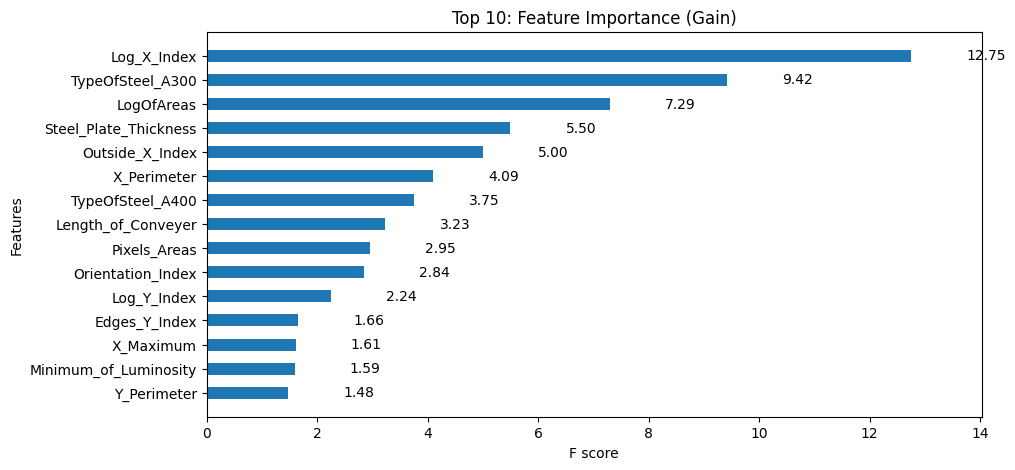

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plot_importance(clf, grid=False, importance_type='gain', 
                values_format="{v:.2f}", ax=ax, max_num_features=15,
                height=.5, title="Top 10: Feature Importance (Gain)")
plt.show()

In [11]:
submission = pd.DataFrame(y_proba, columns=target_features, index=X_test.index)
submission.to_csv('submission.csv')
submission.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
16310,0.041928,0.599190,0.000024,0.000015,0.001565,0.077246,0.280032
573,0.046016,0.005556,0.020134,0.000045,0.003992,0.496950,0.427306
6841,0.323757,0.001029,0.000943,0.000052,0.056047,0.127251,0.490922
14509,0.058918,0.864016,0.000010,0.000008,0.000152,0.015475,0.061421
4462,0.060311,0.000018,0.000021,0.000011,0.000045,0.758342,0.181253
